In [247]:
# References
# https://colab.research.google.com/drive/1IubZ3T7gqD09ZIVmJapiB5MXUnVGlzwH#scrollTo=7LbVjtktg3Ln
# https://medium.com/analytics-vidhya/bert-in-keras-tensorflow-2-0-using-tfhub-huggingface-81c08c5f81d8
# https://medium.com/@brn.pistone/bert-fine-tuning-for-tensorflow-2-0-with-keras-api-9913fc1348f6

# Requirements
# pip install sentencepiece
# pip install tensorflow_hub
# pip install tensorflow
# pip install bert-for-tf2
# pip install transformers

MAX_LENGTH = 128
TRAIN = 10000
TEST = 1000
RETRAIN_BERT = False
print('done')

done


In [248]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import bert
import os
import numpy as np
import random
from datetime import datetime
from tensorflow.keras.layers import Dense, Flatten, Dropout,Embedding, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
import bert
from bert import bert_tokenization 

print('done')

done


In [192]:

bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(bert_path,trainable=True)
print('done')

done


In [193]:
vocab_file1 = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file1, do_lower_case=True)
print('done')

done


In [194]:
print('Sample Tokenizer Operations')
sample_x = tokenizer.tokenize('this is a sample tokening operation. It spans multiple sentences')
sample_ids = tokenizer.convert_tokens_to_ids(sample_x)
print(sample_x)
print(sample_ids)

Sample Tokenizer Operations
['this', 'is', 'a', 'sample', 'token', '##ing', 'operation', '.', 'it', 'spans', 'multiple', 'sentences']
[2023, 2003, 1037, 7099, 19204, 2075, 3169, 1012, 2009, 14798, 3674, 11746]


In [249]:
def cleanup_text(data):
    #observed weird formatting
    data['Text'] = data['Text'].str.replace('\n',' ')
    data['Text'] = data['Text'].str.replace('  ',' ')
    data['Text'] = data['Text'].str.strip()
    data['Text'] = data['Text'].str.lower()
    
    #observed slang
    data['Text'] = data['Text'].str.replace('pls', 'please')
    data['Text'] = data['Text'].str.replace('plz', 'please')
    data['Text'] = data['Text'].str.replace(' u ', ' you ')
    data['Text'] = data['Text'].str.replace(' ur ', ' your ')
    data['Text'] = data['Text'].str.replace(' vs ', ' versus ')
    data['Text'] = data['Text'].str.replace(' tks ', ' thanks ')
    data['Text'] = data['Text'].str.replace(' cud ', ' could ')
    data['Text'] = data['Text'].str.replace(' b ', ' be ')
    data['Text'] = data['Text'].str.replace(' r ', ' are ')
    return data

def Bertify(Set):
    tokens = map(tokenizer.tokenize, Set)
    tokens = map(lambda tok: tok[:MAX_LENGTH-2], tokens)
    tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], tokens)
    token_ids = map(tokenizer.convert_tokens_to_ids, tokens)
    token_ids = map(lambda tids: tids + [0] * (MAX_LENGTH - len(tids)), token_ids)
    # token_ids = map(lambda tids: np.array(tids), token_ids)
    token_ids = list(token_ids)
    token_masks =[]
    sent_segs = []
    for token_list in token_ids:
        token_masks.append([1 if x > 0 else 0 for x in token_list])
        sent_segs.append([0 for x in token_list])
    
    print(type(token_ids))
    print(len(token_ids))
    print(len(token_ids[0]))
    print(token_ids[0:2])
    
    print(type(token_masks))
    print(len(token_masks))
    print(len(token_masks[0]))
    print(token_masks[0:2])
    
    print(type(sent_segs))
    print(len(sent_segs))
    print(len(sent_segs[0]))
    print(sent_segs[0:2])
    
    return  [tf.cast(token_ids,tf.int32), tf.cast(sent_segs,tf.int32), tf.cast(token_masks,tf.int32)]

def load_data():
    data = pd.read_csv('Data/agr_en_train.csv')
    data.columns = ['ID','Text','Indicator']
    
    data = cleanup_text(data)
    data.drop(['ID'], axis='columns', inplace = True)
    
    #One hot encoding
    label_encoder = LabelEncoder()
    label_ints = label_encoder.fit_transform(data.values[:,1])
    label_ints = label_ints.reshape(len(label_ints), 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    label_onehot = onehot_encoder.fit_transform(label_ints)
    
    #Split to training and test
    train_set = data.values[:TRAIN,0]
    train_features = Bertify(train_set)
    train_labels = np.array(label_onehot[:TRAIN,:])
    
    test_set = data.values[len(data)-TEST:,0]
    test_features = Bertify(test_set)
    test_labels = np.array(label_onehot[len(data)-TEST:,:])
    
    return train_features, train_labels, test_features, test_labels

train_tokens, train_labels, test_tokens, test_labels = load_data()
print(train_tokens[0:10])
print(train_labels[0:10])


<class 'list'>
10000
128
[[101, 2087, 1997, 2797, 5085, 27218, 1005, 1055, 2066, 10751, 11329, 1010, 24582, 28775, 4385, 2024, 2041, 1997, 5356, 1012, 2069, 2270, 4753, 2924, 1005, 1055, 27218, 2551, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2085, 3160, 2003, 1010, 4501, 2097, 25276, 2000, 2023, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
<class 'list'>
10000
128
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [250]:
METRICS = [
      tf.keras.metrics.CategoricalCrossentropy(name='categoricalcrossentropy'),
      tf.keras.metrics.CategoricalAccuracy(name='categoricalaccuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

def build_model_fullyconnected():
    """add pretrained bert model as a keras layer"""
    input_word_ids = Input((MAX_LENGTH,), dtype=tf.int32, name='input_token_ids')
    input_masks = Input((MAX_LENGTH,), dtype=tf.int32, name='input_token_masks')
    input_segments = Input((MAX_LENGTH,), dtype=tf.int32, name='input_sent_segms')
    
    if not RETRAIN_BERT:
        bert_layer.trainable = False
    
    _, sout = bert_layer([input_word_ids, input_masks, input_segments])
    X = GlobalAveragePooling1D()(sout)
    X = Dense(100, activation='relu')(X) 
    X = Dropout(0.3)(X)
    X = Dense(33, activation='relu')(X) 
    X = Dropout(0.3)(X)
    output_= Dense(3, activation=tf.nn.softmax, name='output')(X)

    #model = Model(input_,output_)
    model = Model([input_word_ids, input_masks, input_segments],output_)
    model.compile(optimizer = "adam",loss = "categorical_crossentropy",
                    metrics = METRICS)
    print(model.summary())

    return model

model = build_model_fullyconnected()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token_ids (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_token_masks (InputLayer)  [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_sent_segms (InputLayer)   [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_6 (KerasLayer)      [(None, 768), (None, 109482241   input_token_ids[0][0]            
                                                                 input_token_masks[0][0]   

In [251]:
def fitModel(Model, training_set, training_label, testing_set, testing_label):
    checkpointName = os.path.join('Model', "bert_faq.ckpt")

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointName,
                                                     save_weights_only=True,
                                                     save_freq = 10000,
                                                     mode='auto',
                                                     verbose=1)
    # callback = StopTrainingClassComplete()

    history = Model.fit(
        training_set,
        training_label,
        epochs=50,
        validation_data=(testing_set, testing_label),
        verbose=1,
        callbacks=[cp_callback]
    )
    return history
    
history = fitModel(model, train_tokens, train_labels, test_tokens, test_labels)

Train on 10000 samples, validate on 1000 samples
Epoch 1/50
 9984/10000 [============================>.] - ETA: 0s - loss: 1.0802 - categoricalcrossentropy: 1.0802 - categoricalaccuracy: 0.4036 - precision: 0.4382 - recall: 0.0586 - auc: 0.5915
Epoch 00001: saving model to Model\bert_faq.ckpt
10000/10000 [==============================] - 150s 15ms/sample - loss: 1.0801 - categoricalcrossentropy: 1.0801 - categoricalaccuracy: 0.4041 - precision: 0.4382 - recall: 0.0585 - auc: 0.5917 - val_loss: 1.0560 - val_categoricalcrossentropy: 1.0560 - val_categoricalaccuracy: 0.4480 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6371
Epoch 2/50
 9984/10000 [============================>.] - ETA: 0s - loss: 1.0626 - categoricalcrossentropy: 1.0626 - categoricalaccuracy: 0.4336 - precision: 0.5059 - recall: 0.0473 - auc: 0.6143
Epoch 00002: saving model to Model\bert_faq.ckpt
10000/10000 [==============================] - 147s 15ms/sample - loss: 1.0625 - categoricalcrossentropy:

Epoch 15/50
 9984/10000 [============================>.] - ETA: 0s - loss: 0.9887 - categoricalcrossentropy: 0.9887 - categoricalaccuracy: 0.4891 - precision: 0.6608 - recall: 0.1706 - auc: 0.6877
Epoch 00015: saving model to Model\bert_faq.ckpt
10000/10000 [==============================] - 144s 14ms/sample - loss: 0.9884 - categoricalcrossentropy: 0.9884 - categoricalaccuracy: 0.4895 - precision: 0.6612 - recall: 0.1708 - auc: 0.6880 - val_loss: 0.9551 - val_categoricalcrossentropy: 0.9551 - val_categoricalaccuracy: 0.4880 - val_precision: 0.6493 - val_recall: 0.2370 - val_auc: 0.7120
Epoch 16/50
 9984/10000 [============================>.] - ETA: 0s - loss: 0.9897 - categoricalcrossentropy: 0.9897 - categoricalaccuracy: 0.4928 - precision: 0.6380 - recall: 0.1488 - auc: 0.6895
Epoch 00016: saving model to Model\bert_faq.ckpt
10000/10000 [==============================] - 145s 14ms/sample - loss: 0.9899 - categoricalcrossentropy: 0.9899 - categoricalaccuracy: 0.4926 - precision: 0.63

Epoch 29/50
 9984/10000 [============================>.] - ETA: 0s - loss: 0.9687 - categoricalcrossentropy: 0.9687 - categoricalaccuracy: 0.5134 - precision: 0.6418 - recall: 0.2112 - auc: 0.7077
Epoch 00029: saving model to Model\bert_faq.ckpt
10000/10000 [==============================] - 144s 14ms/sample - loss: 0.9690 - categoricalcrossentropy: 0.9690 - categoricalaccuracy: 0.5132 - precision: 0.6416 - recall: 0.2112 - auc: 0.7073 - val_loss: 0.9475 - val_categoricalcrossentropy: 0.9475 - val_categoricalaccuracy: 0.5110 - val_precision: 0.7079 - val_recall: 0.2230 - val_auc: 0.7203
Epoch 30/50
 9984/10000 [============================>.] - ETA: 0s - loss: 0.9633 - categoricalcrossentropy: 0.9633 - categoricalaccuracy: 0.5066 - precision: 0.6537 - recall: 0.2125 - auc: 0.7085
Epoch 00030: saving model to Model\bert_faq.ckpt
10000/10000 [==============================] - 145s 14ms/sample - loss: 0.9633 - categoricalcrossentropy: 0.9633 - categoricalaccuracy: 0.5066 - precision: 0.65

Epoch 43/50
 9984/10000 [============================>.] - ETA: 0s - loss: 0.9586 - categoricalcrossentropy: 0.9586 - categoricalaccuracy: 0.5230 - precision: 0.6271 - recall: 0.2664 - auc: 0.7166
Epoch 00043: saving model to Model\bert_faq.ckpt
10000/10000 [==============================] - 144s 14ms/sample - loss: 0.9586 - categoricalcrossentropy: 0.9586 - categoricalaccuracy: 0.5230 - precision: 0.6268 - recall: 0.2664 - auc: 0.7166 - val_loss: 0.9391 - val_categoricalcrossentropy: 0.9391 - val_categoricalaccuracy: 0.5230 - val_precision: 0.6885 - val_recall: 0.2520 - val_auc: 0.7304
Epoch 44/50
 9984/10000 [============================>.] - ETA: 0s - loss: 0.9461 - categoricalcrossentropy: 0.9461 - categoricalaccuracy: 0.5249 - precision: 0.6526 - recall: 0.2531 - auc: 0.7233
Epoch 00044: saving model to Model\bert_faq.ckpt
10000/10000 [==============================] - 146s 15ms/sample - loss: 0.9459 - categoricalcrossentropy: 0.9459 - categoricalaccuracy: 0.5250 - precision: 0.65

In [227]:
print(history)

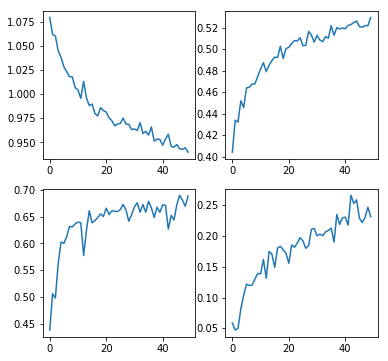

In [252]:
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=2, figsize=(6,6),sharey=False)
ax1[0].plot(history.history['categoricalcrossentropy'])
ax1[1].plot(history.history['categoricalaccuracy'])
ax2[0].plot(history.history['precision'])
ax2[1].plot(history.history['recall'])
plt.show()